In [1]:
import RAPIDpy
from RAPIDpy.rapid import Popen, PIPE
from RAPIDpy import RAPID
from imports import *
import time
import xarray as xr
from torch_function import block_sparse_conv_1d_autograd
from gen_data import generate_inputs
sys.path.append("../jphydro")
from jphydro.routing.block_sparse_conv import BlockSparseCausalConv
from jphydro.routing.kernel_aggregator_irf import RoutingIRFAggregator

### RAPID dumping helpers

In [2]:
import netCDF4 as nc
import cftime
import os, subprocess, re
from pathlib import Path

def create_rapid_connect_from_digraph(g, output_csv='rapid_connect.csv'):
    import csv
    max_up = max(len(list(g.predecessors(n))) for n in g.nodes())
    sorted_nodes = sorted(g.nodes())
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        for node in sorted_nodes:
            downstreams = list(g.successors(node))
            if len(downstreams) == 0:
                next_down = 0  # outlet
            elif len(downstreams) == 1:
                next_down = downstreams[0]
            else:
                raise ValueError(f"Node {node} has multiple downstreams. Usually unexpected in simple RAPID runs.")
            
            upstreams = sorted(g.predecessors(node))
            nup = len(upstreams)
            row = [node, next_down, nup] + upstreams
            missing_cols = max_up - nup
            if missing_cols > 0:
                row += [0]*missing_cols
            writer.writerow(row)

def create_inflow_netcdf_from_dataframe(df, out_nc='m3_riv_bas_2021010100.nc'):
    """
    Creates a NetCDF of inflows in the format RAPID expects:
    Dimensions:
        time
        rivid
    Variables:
        time (hours since 1900-01-01 00:00:00)
        rivid (reach IDs)
        m3_riv (float array of shape [time, rivid])
    """
    time_vals = df.index.to_pydatetime()          # pandas timestamps -> Python datetimes
    n_time = len(time_vals)
    rivid_vals = df.columns.to_numpy()            # e.g. [1001, 1002, 1003]
    n_rivid = len(rivid_vals)
    
    # Choose a reference time for "units" used by netCDF
    ref_time = cftime.DatetimeGregorian(1900, 1, 1, 0, 0, 0)
    time_units = "hours since 1900-01-01 00:00:00"
    
    # Convert datetimes to numeric "hours since ref_time"
    time_in_hours = nc.date2num(time_vals, units=time_units, calendar='gregorian')
    
    with nc.Dataset(out_nc, 'w', format='NETCDF4') as ds:
        # Create Dimensions
        ds.createDimension('time', n_time)
        ds.createDimension('rivid', n_rivid)
        
        # time variable
        time_var = ds.createVariable('time', 'i4', ('time',))
        time_var.units = time_units
        time_var.long_name = "time"
        time_var[:] = time_in_hours
        
        # rivid variable
        rivid_var = ds.createVariable('rivid', 'i4', ('rivid',))
        rivid_var.long_name = "unique identifier for each river reach"
        rivid_var[:] = rivid_vals
        
        # inflow variable (m^3/s)
        inflow_var = ds.createVariable('m3_riv', 'f4', ('time','rivid'))
        inflow_var.long_name = "river inflow"
        inflow_var.units = "m^3/s"
        inflow_var[:,:] = df.values
        
        # Optional global attrs
        ds.Conventions = "CF-1.6"
        ds.title = "Example inflow for RAPID"
        ds.history = f"Created by script on {pd.Timestamp.now()}"
    
    print(f"Created inflow NetCDF: {os.path.abspath(out_nc)}")

In [7]:
RAPID_DATA_ROOT = Path("./rapid_data/")

def run_rapid(x, g, unit=3600*24, **kwargs):
    dump_rapid_data(x, g)
    n_nodes, n_time = x.squeeze().shape
    return run_rapid_exec(ZS_TauM=n_time*unit)

def dump_rapid_data(x, g):
    df_inflow = pd.DataFrame(x.squeeze().t().cpu().detach().numpy(), columns=list(g.nodes))
    xr.DataArray(df_inflow).to_netcdf(RAPID_DATA_ROOT / "new_inp.nc")
    create_rapid_connect_from_digraph(g, output_csv=RAPID_DATA_ROOT / 'rapid_connectivity.csv')
    with open(RAPID_DATA_ROOT / "riv_bas_id.csv", "w") as f: f.write("\n".join([str(x) for x in g.nodes]))
    with open(RAPID_DATA_ROOT / "x.csv", "w") as f: f.write("\n".join(["0.3" for x in g.nodes]))
    with open(RAPID_DATA_ROOT / "k.csv", "w") as f: f.write("\n".join(["800" for x in g.nodes]))

def run_rapid_exec(ZS_TauM=3600*24*365*10,
                   ZS_TauR=3600*24,
                   ZS_dtM =3600*24,
                   ZS_dtR =3600*24):
    rapid_manager = RAPID(rapid_executable_location="/home/tristan/installz/rapid/tst/rapid")
    rapid_manager.update_parameters(
            rapid_connect_file=RAPID_DATA_ROOT / 'rapid_connectivity.csv',
            riv_bas_id_file=RAPID_DATA_ROOT / 'riv_bas_id.csv',
            Vlat_file=RAPID_DATA_ROOT / "new_inp.nc",
            k_file = RAPID_DATA_ROOT / "k.csv",
            x_file = RAPID_DATA_ROOT / "x.csv",
            ZS_TauM=ZS_TauM, ZS_TauR=ZS_TauR,
            ZS_dtM =ZS_dtM, ZS_dtR =ZS_dtR,
            Qout_file=RAPID_DATA_ROOT / 'rapid_qout.nc',
    )
    rapid_manager.update_reach_number_data()
    temp_rapid_namelist_file = os.path.join(os.getcwd(), "rapid_namelist")
    rapid_manager.generate_namelist_file(temp_rapid_namelist_file)
    
    cmd = str(RAPID_DATA_ROOT / "rapid_exe_symlink")
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    match = re.search(r"Cumulative time for routing only\s+Rank\s+:\s+\d+,\s+Time\s+:\s+([\d.]+)", result.stdout)
    x = float(match.group(1)) if match else None
    return x

### ok

In [4]:
n_trees = 1
max_heights = 100
n_time_steps = 365
max_delay = 10
block_size = 32
batch_size = 1
BLOCK_SIZE_N = 64
device = "cuda:0"
BLOCK_SIZE_M = block_size

In [5]:
timings = []
for n_trees in [1, 5, 10]:
    for max_heights in [10, 50, 100]:
        for n_time_steps in [365, 365*5, 365*10]:
            g, x, k = generate_inputs(n_trees, max_heights, max_delay, block_size, n_time_steps, batch_size)
            out = run_rapid(x, g)
            timings.append([n_trees, max_heights, n_time_steps, out])

INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating RAPID namelist file ...
INFO: Generating

In [9]:
df = pd.DataFrame(timings)

In [16]:
from imports import *

In [19]:
import hvplot.pandas

<Axes: xlabel='1', ylabel='3'>

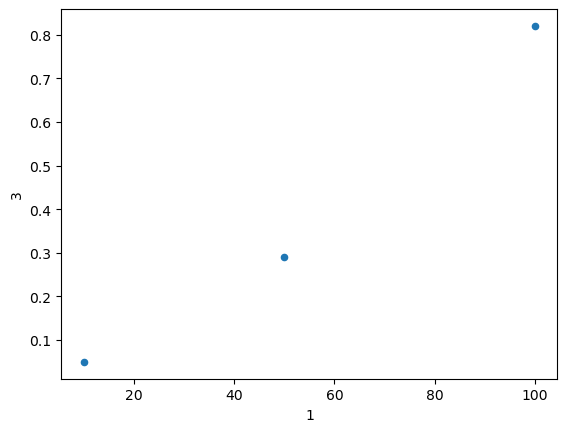

In [23]:
df[(df[2]==3650) & (df[0]==5)].plot.scatter(x=1, y=3)

In [11]:
df[df[0]==10]

,0,1,2,3
18,10,10,365,0.01
19,10,10,1825,0.05
20,10,10,3650,0.11
21,10,50,365,0.08
22,10,50,1825,0.40
23,10,50,3650,0.69
24,10,100,365,0.17
25,10,100,1825,0.87
26,10,100,3650,1.57
